In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor

C:\Users\skander\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_arn = pd.read_csv('donnees brutes/MAARS_normTranscriptome_618samples_16042014.txt', sep='\t').T # donnees de transcriptome
df_clin = pd.read_csv('encoded/MAARS_AD_full_20190131_12-34-49_new_cols_encoded.csv', sep=',') # donnees cliniques

In [3]:
df_clin = df_clin[['involved_skin_biopsy->MAARS_Sample_identifier','uninvolved_skin_biopsy->MAARS_Sample_identifier','patient->SCORAD_index->SCORAD->SCORAD_Score']]
df_clin.columns = ['id_les', 'id_non_les', 'scorad']

In [4]:
df_temp_les = df_clin[['id_les', 'scorad']]
df_temp_non_les = df_clin[['id_non_les', 'scorad']]

#df_temp_les = df_temp.append(df_temp2)
df_temp_les.set_index(['id_les'], inplace=True)

df_arn_ad = df_temp_les.join(df_arn).dropna()

In [5]:
df_arn_ad.head()

,scorad,ENSG00000000003_at,ENSG00000000005_at,ENSG00000000419_at,ENSG00000000457_at,ENSG00000000460_at,ENSG00000000938_at,ENSG00000000971_at,ENSG00000001036_at,ENSG00000001084_at,...,ENSG00000266786_at,ENSG00000266795_at,ENSG00000266824_at,ENSG00000266835_at,ENSG00000266844_at,ENSG00000266852_at,ENSG00000266855_at,ENSG00000266865_at,ENSG00000266869_at,ENSG00000266877_at
id_les,,,,,,,,,,,,,,,,,,,,,
MAARS_1_003_03,43.5,7.139,4.285,9.363,7.097,6.054,4.635,9.364,7.803,6.993,...,2.963,2.264,2.517,2.612,3.441,5.091,1.622,5.336,2.577,3.714
MAARS_1_008_03,57.5,7.282,4.058,9.427,7.043,6.025,4.449,8.690,7.116,7.299,...,2.850,1.798,2.600,2.648,3.424,4.887,1.734,5.215,2.771,3.941
MAARS_1_016_03,73.0,7.441,3.881,9.597,6.990,6.336,5.228,8.499,7.364,6.809,...,3.283,1.770,2.496,2.789,3.493,4.475,1.720,5.377,2.410,4.348
MAARS_1_017_03,78.5,7.019,3.571,10.010,6.993,5.692,4.850,8.728,6.634,7.053,...,3.050,2.704,2.450,2.641,3.318,5.427,1.684,5.374,2.326,4.172
MAARS_1_044_03,64.5,7.115,3.844,9.752,7.248,5.923,4.439,7.626,6.818,7.105,...,3.424,2.058,2.748,2.827,3.212,4.922,2.139,5.393,2.709,3.933


In [6]:
df_arn_ad.shape

(83, 32634)

# Variance Threshold

In [7]:
thr = VarianceThreshold()
thr.fit(df_arn_ad)

VarianceThreshold(threshold=0.0)

On représente le nombre de gènes en fonction d'un seuil de variance. (le nombre de gènes ayant une variance inférieure à ce seuil)

In [8]:
def threshold(alpha):
    thr = VarianceThreshold(alpha)
    x = thr.fit_transform(df_arn_ad)
    return x.shape[1]

x_thr = np.linspace(0,2,501)
y_thr = [df_arn_ad.shape[1]-threshold(x) for x in x_thr]

Text(0.09,22000,'(0.069388, 21500)')

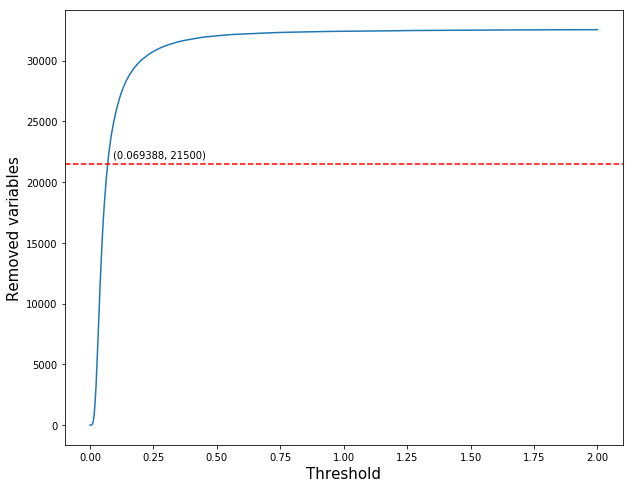

In [9]:
fig, ax = plt.subplots(figsize=(10,8))

sns.lineplot(x_thr, y_thr)
ax.set_xlabel('Threshold', size = 15)
ax.set_ylabel('Removed variables', size = 15)

ax.axhline(21500,ls='--', color='red')
plt.text(0.09, 22000, '(0.069388, 21500)')

In [20]:
df_arn_ad.shape[1] - threshold(0.069388)

21500

On choisit une threshold of variance de sorte à éliminer 21500 gènes

In [16]:
chosen_thr = 0.069388
thr = VarianceThreshold(chosen_thr)

df_arn_ad_filtered = thr.fit_transform(df_arn_ad)

In [17]:
useful_var_genes = [g for m, g in zip(thr.get_support(), df_arn_ad.columns.tolist()) if m]
useless_var_genes = [g for m, g in zip(thr.get_support(), df_arn_ad.columns.tolist()) if not m]

df_arn_ad_filtered = pd.DataFrame(df_arn_ad_filtered)
df_arn_ad_filtered.columns = useful_var_genes
df_arn_ad_filtered.index = df_arn_ad.index

In [18]:
df_arn_ad_filtered.shape

(83, 11134)

In [19]:
df_arn_ad_filtered.head()

,scorad,ENSG00000000003_at,ENSG00000000005_at,ENSG00000000460_at,ENSG00000000938_at,ENSG00000000971_at,ENSG00000001036_at,ENSG00000001561_at,ENSG00000001626_at,ENSG00000002016_at,...,ENSG00000266645_at,ENSG00000266665_at,ENSG00000266667_at,ENSG00000266705_at,ENSG00000266751_at,ENSG00000266786_at,ENSG00000266795_at,ENSG00000266824_at,ENSG00000266852_at,ENSG00000266877_at
id_les,,,,,,,,,,,,,,,,,,,,,
MAARS_1_003_03,43.5,7.139,4.285,6.054,4.635,9.364,7.803,6.234,4.689,6.114,...,2.892,3.065,3.142,3.001,5.948,2.963,2.264,2.517,5.091,3.714
MAARS_1_008_03,57.5,7.282,4.058,6.025,4.449,8.690,7.116,5.761,4.262,6.199,...,2.739,3.339,3.542,2.669,6.092,2.850,1.798,2.600,4.887,3.941
MAARS_1_016_03,73.0,7.441,3.881,6.336,5.228,8.499,7.364,5.987,4.254,6.510,...,2.852,3.923,3.206,2.977,6.453,3.283,1.770,2.496,4.475,4.348
MAARS_1_017_03,78.5,7.019,3.571,5.692,4.850,8.728,6.634,5.644,5.132,5.859,...,3.267,4.344,2.936,3.744,6.388,3.050,2.704,2.450,5.427,4.172
MAARS_1_044_03,64.5,7.115,3.844,5.923,4.439,7.626,6.818,4.710,3.965,6.169,...,3.160,4.056,2.474,3.008,6.303,3.424,2.058,2.748,4.922,3.933


# Test Stat : f_regression

On teste l'influence des gènes sur le scorad par un test statistique et on représente la distribution du score résultant de ce test

In [20]:
k_best = SelectKBest(f_regression, k = 200)
df_filtered_two = k_best.fit_transform(df_arn_ad_filtered.iloc[:,1:], df_arn_ad_filtered.iloc[:,0])

Text(2.4,0.12,'(2.24, 0.112)')

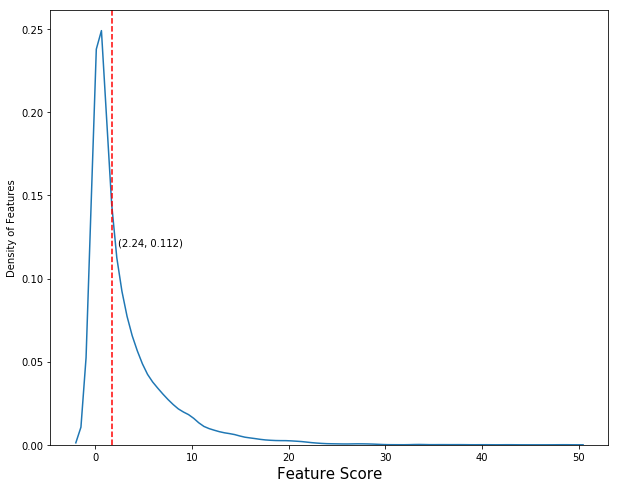

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(k_best.scores_)
ax.set_xlabel('Feature Score', size = 15)
ax.set_ylabel('Density of Features')
ax.axvline(1.78, ls='--', color='red')

plt.text(2.4 ,0.12, '(2.24, 0.112)')

On sélectionne les gènes ayant un score supérieur à 1.78%

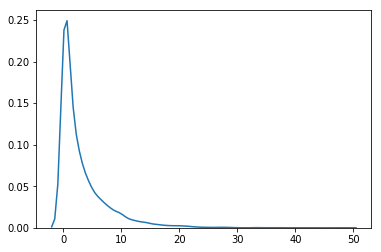

In [22]:
x, y  = sns.kdeplot(k_best.scores_).get_lines()[0].get_data()

In [23]:
thr_score = x[8]

In [24]:
thr_score

2.2420433894249054

In [25]:
y[8]

0.11249803535453096

In [28]:
df_arn_ad_filtered.shape

(83, 11134)

In [29]:
mask_k = [(score > thr_score) for score in k_best.scores_]
useful_filtered_genes = [g for m, g in zip(mask_k, df_arn_ad_filtered.iloc[:,1:].columns.tolist()) if m]

df_filtered_best = df_arn_ad_filtered.loc[:,['scorad'] + useful_filtered_genes]

In [30]:
len(useful_filtered_genes)

4581

In [31]:
df_filtered_best.shape

(83, 4582)

# ElasticNet

In [32]:
df_filtered_best.head()

,scorad,ENSG00000000003_at,ENSG00000000005_at,ENSG00000000460_at,ENSG00000000938_at,ENSG00000000971_at,ENSG00000001561_at,ENSG00000001626_at,ENSG00000002016_at,ENSG00000002587_at,...,ENSG00000265996_at,ENSG00000266299_at,ENSG00000266324_at,ENSG00000266433_at,ENSG00000266509_at,ENSG00000266559_at,ENSG00000266614_at,ENSG00000266640_at,ENSG00000266824_at,ENSG00000266852_at
id_les,,,,,,,,,,,,,,,,,,,,,
MAARS_1_003_03,43.5,7.139,4.285,6.054,4.635,9.364,6.234,4.689,6.114,3.959,...,6.817,3.358,4.326,3.854,4.906,4.457,3.290,5.131,2.517,5.091
MAARS_1_008_03,57.5,7.282,4.058,6.025,4.449,8.690,5.761,4.262,6.199,4.095,...,6.542,3.509,4.438,3.673,4.586,4.375,3.276,5.625,2.600,4.887
MAARS_1_016_03,73.0,7.441,3.881,6.336,5.228,8.499,5.987,4.254,6.510,4.526,...,6.269,3.022,4.399,3.735,4.787,4.503,2.796,5.630,2.496,4.475
MAARS_1_017_03,78.5,7.019,3.571,5.692,4.850,8.728,5.644,5.132,5.859,4.337,...,6.744,2.871,4.369,4.047,4.841,4.528,2.939,5.332,2.450,5.427
MAARS_1_044_03,64.5,7.115,3.844,5.923,4.439,7.626,4.710,3.965,6.169,3.727,...,6.809,3.683,4.420,4.094,5.245,4.003,2.628,5.429,2.748,4.922


In [33]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(l1_ratio = .001)

In [34]:
elastic.fit(df_filtered_best.iloc[:,1:], df_filtered_best.iloc[:,0])

C:\Users\skander\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [35]:
len(elastic.coef_[elastic.coef_!=0])

4505

In [36]:
elastic_genes = df_filtered_best.iloc[:,1:].columns[elastic.coef_!=0]

In [37]:
result = pd.DataFrame( {'Genes': elastic_genes, 'ElasticNet coef (abs)' : abs(elastic.coef_[elastic.coef_!=0]),
                       'ElasticNet coef' : elastic.coef_[elastic.coef_!=0]}).sort_values(by='ElasticNet coef (abs)', ascending=False)

In [38]:
result.head()

,ElasticNet coef,ElasticNet coef (abs),Genes
2281,-0.494417,0.494417,ENSG00000170345_at
3687,0.475388,0.475388,ENSG00000227827_at
847,-0.340621,0.340621,ENSG00000116690_at
67,0.313179,0.313179,ENSG00000012223_at
3366,0.291081,0.291081,ENSG00000211952_at


In [52]:
result.to_csv('genes_elasticnet.csv')